In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv(r'C:\Users\Mohamed Fawzi\OneDrive\Área de Trabalho\Stock Price Analysis\Stock Prices Data Set.csv')

df.head()

,symbol,date,open,high,low,close,volume
0,AAL,2014-01-02,25.0700,25.8200,25.0600,25.3600,8998943
1,AAPL,2014-01-02,79.3828,79.5756,78.8601,79.0185,58791957
2,AAP,2014-01-02,110.3600,111.8800,109.2900,109.7400,542711
3,ABBV,2014-01-02,52.1200,52.3300,51.5200,51.9800,4569061
4,ABC,2014-01-02,70.1100,70.2300,69.4800,69.8900,1148391


## Preparing & Cleaning Data:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497472 entries, 0 to 497471
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  497472 non-null  object 
 1   date    497472 non-null  object 
 2   open    497461 non-null  float64
 3   high    497464 non-null  float64
 4   low     497464 non-null  float64
 5   close   497472 non-null  float64
 6   volume  497472 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 26.6+ MB


In [4]:
# Statistics of the dataset
df.describe()

,open,high,low,close,volume
count,497461.000000,497464.000000,497464.000000,497472.000000,4.974720e+05
mean,86.352275,87.132562,85.552467,86.369082,4.253611e+06
std,101.471228,102.312062,100.570957,101.472407,8.232139e+06
min,1.620000,1.690000,1.500000,1.590000,0.000000e+00
25%,41.690000,42.090000,41.280000,41.703750,1.080166e+06
50%,64.970000,65.560000,64.353700,64.980000,2.084896e+06
75%,98.410000,99.230000,97.580000,98.420000,4.271928e+06
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08


In [5]:
#checking for null values
df.isnull().sum()

symbol     0
date       0
open      11
high       8
low        8
close      0
volume     0
dtype: int64

In [6]:
# filling null values with previous values
df.fillna(method='ffill', inplace=True)

In [7]:
# convert the 'Date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497472 entries, 0 to 497471
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   symbol  497472 non-null  object        
 1   date    497472 non-null  datetime64[ns]
 2   open    497472 non-null  float64       
 3   high    497472 non-null  float64       
 4   low     497472 non-null  float64       
 5   close   497472 non-null  float64       
 6   volume  497472 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 26.6+ MB


## Exploratory Data Analysis (EDA):

In [9]:
# the top 10 symbols by volume
top_10_symbols = df.groupby('symbol')['volume'].sum().nlargest(10).reset_index()
top_10_symbols

,symbol,volume
0,BAC,89988444028
1,AAPL,45485758169
2,GE,41734050117
3,AMD,33522535638
4,F,33144701045
5,MSFT,30927601441
6,FB,29432418373
7,MU,28158553783
8,CHK,28080599383
9,INTC,27351266285


In [21]:
# mapping symbols to their respective full names
symbol_name = {
    'BAC': 'Bank of America',
    'AAPL': 'Apple Inc.',
    'GE': 'General Electric',
    'AMD': 'Advanced Micro Devices',
    'F': 'Ford Motor Company',
    'MSFT': 'Microsoft Corporation',
    'FB': 'Meta Platforms',
    'MU': 'Micron Technology',
    'CHK': 'Chesapeake Energy',
    'INTC': 'Intel Corporation'
}

top_10_symbols['company name'] = top_10_symbols['symbol'].map(symbol_name)


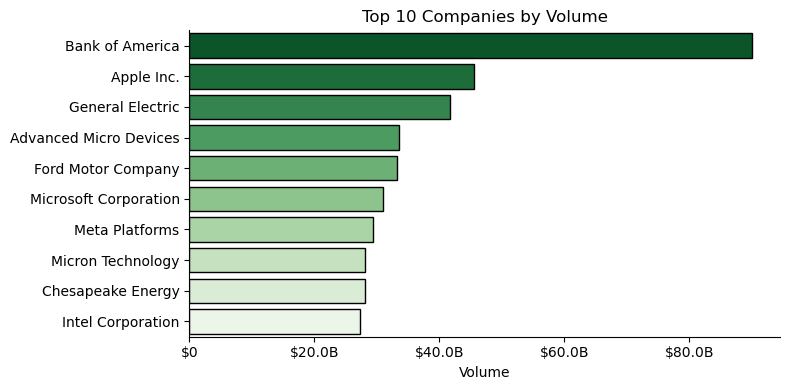

In [28]:
plt.figure(figsize=(8, 4))
sns.barplot(
    data=top_10_symbols,
    y='company name',
    x='volume',
    palette='Greens_r',
    edgecolor='black',    
)

def currency(x, pos):
    if x >= 1e9:
        return f'${x*1e-9:.1f}B'
    elif x >= 1e6:
        return f'${x*1e-6:.1f}M'
    elif x >= 1e3:
        return f'${x*1e-3:.1f}K'
    else:
        return f'${x:.0f}'

plt.gca().xaxis.set_major_formatter(FuncFormatter(currency))

plt.title('Top 10 Companies by Volume')
plt.xlabel('Volume')
plt.ylabel('')



sns.despine()
plt.tight_layout()
plt.show()